In [1]:
# Import packages
import pandas as pd
import numpy as np
import math
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

from hyperopt import *
import pyspark 
import mlflow

import seaborn as sns

import warnings

In [2]:
# Import Data
train = pd.read_csv("..\\Predictive Models\\Datasets\\17zScoreSMOTE_0.75_newlabel.csv", delimiter=',')
test = pd.read_csv("..\\Predictive Models\\Datasets\\172zScore_newlabel.csv", delimiter=',')
validation = pd.read_csv("..\\Predictive Models\\Datasets\\18zScore_newlabel.csv", delimiter=',')
validation2 = pd.read_csv("..\\Predictive Models\\Datasets\\19zScore_newlabel.csv", delimiter=',')

# Define X and y
X_train = (train.drop(labels=["label"], axis=1))
y_train = train[["label"]]
X_test = test.drop(labels=["label","c28992r100"], axis=1)
y_test =test[["label"]]

X_val1 = validation.drop(labels=["label","c28992r100"], axis=1)
y_val1 = validation[["label"]]
X_val2 = validation2.drop(labels=["label","c28992r100"], axis=1)
y_val2 = validation2[["label"]]

# Make column list
columns = X_train.columns

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

# Define hyperopt settings

In [3]:
import warnings
warnings.filterwarnings("ignore")

start_time = time.time()
# Define objectives
def objective(params):
    classifier_type = params['type']
    del params['type']
    if classifier_type == 'rf':
        clf = RandomForestClassifier(**params,
                                     max_features = 1.0,
                                     n_jobs=-1)
    else:
        return 0
    classifier = clf
    print(classifier)
    classifier.fit(X_train, y_train)
    pr_rf = classifier.predict(X_train)
    accuracy = accuracy_score(y_train,pr_rf)
    f1 = f1_score(y_train,pr_rf)
    recall = recall_score(y_train,pr_rf)
    print(accuracy, f1, recall)

    # Because fmin() tries to minimize the objective, this function must return the negative accuracy. 
    return {'loss': -accuracy, 'status': STATUS_OK}

# Define search space
space = hp.choice('classifier_type', [
        {
            "type": 'rf',
            'n_estimators':hp.choice('n_estimators',range(50,400,50)),
           'max_depth':hp.choice('max_depth',range(2,10)),
           'min_samples_leaf':hp.choice('min_samples_leaf',range(1,10)),
           'min_samples_split':hp.choice('min_samples_split',range(2,10))}
])
    
with mlflow.start_run():
    best = fmin(
    fn=objective, 
    space=space,
    algo=tpe.suggest,
    max_evals=30, 
    verbose = 1,
    return_argmin=False)
    
print("--- %s seconds ---" % (time.time() - start_time))

RandomForestClassifier(max_depth=8, max_features=1.0, min_samples_leaf=3,                                              
                       min_samples_split=6, n_estimators=150, n_jobs=-1)
0.8375480188565116                                                                                                     
0.7866165464458668                                                                                                     
0.6986737498727429                                                                                                     
RandomForestClassifier(max_depth=4, max_features=1.0, min_samples_leaf=4,                                              
                       min_samples_split=6, n_jobs=-1)
0.7178424882345125                                                                                                     
0.6528291573532714                                                                                                     
0.6190061916352766              

RandomForestClassifier(max_depth=7, max_features=1.0, min_samples_leaf=6,                                              
                       min_samples_split=8, n_jobs=-1)
0.8235404944975399                                                                                                     
0.7408652193920049                                                                                                     
0.5885801812140788                                                                                                     
RandomForestClassifier(max_depth=3, max_features=1.0, min_samples_leaf=8,                                              
                       min_samples_split=7, n_estimators=350, n_jobs=-1)
0.6393245925958245                                                                                                     
0.2735156771180787                                                                                                     
0.15842349304482226             

0.6820100139751409                                                                                                     
100%|███████████████████████████████████████████| 30/30 [9:49:41<00:00, 1179.39s/trial, best loss: -0.8636274391199237]
--- 35386.061074733734 seconds ---


In [4]:
# Results
print(best)

{'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 250, 'type': 'rf'}


In [5]:
# Fitting Randomforest to the Training set
classifier = RandomForestClassifier(n_estimators = best['n_estimators'],
                            max_depth = best['max_depth'],
                            min_samples_leaf = int(best['min_samples_leaf']),
                            min_samples_split= int(best['min_samples_split']),
                                     max_features = 1.0,
                           n_jobs = -1)
classifier.fit(X_train, y_train)
pr_rf = classifier.predict(X_train)
accuracy = accuracy_score(y_train,pr_rf)
f1 = f1_score(y_train,pr_rf)
recall = recall_score(y_train,pr_rf)
print(accuracy, f1, recall)
print(roc_auc_score(y_train, classifier.predict_proba(X_train)[:, 1]))

0.8626774739255378 0.8092832629137724 0.6798304472970597
0.9206508433243278


# Results

Accuracy:0.1471616895345709
F1:0.054295942720763726
Recall:0.8504672897196262


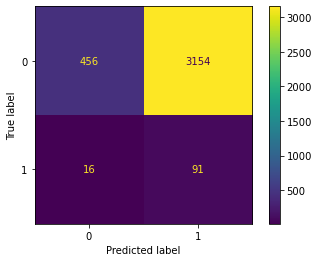

Accuracy:0.10800673524237159
F1:0.06526374129769655
Recall:0.9196684730634364


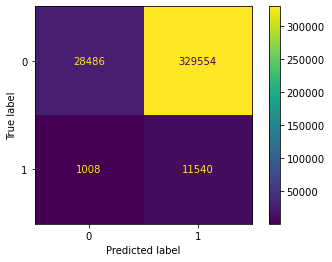

Accuracy:0.10758170285960009
F1:0.040251230573130584
Recall:0.8975251353441609


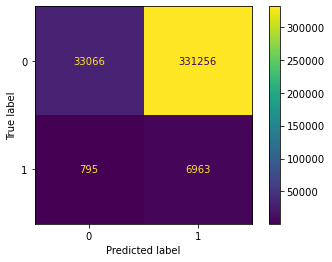

In [6]:
# Make confusion matrixes, accuracy, recall and f1 score for testset
p_rf = classifier.predict(X_test)
print("Accuracy:" + str(classifier.score(X_test, y_test)))
print("F1:" + str(f1_score(y_test,p_rf)))
print("Recall:" + str(recall_score(y_test,p_rf)))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,p_rf),display_labels=classifier.classes_).plot()
plt.savefig('con_test_rf_z_smote.png', dpi=300)
plt.show()

# Make confusion matrixes, accuracy, recall and f1 score for validationset 1
pre_rf = classifier.predict(X_val1)
print("Accuracy:" + str(classifier.score(X_val1, y_val1)))
print("F1:" + str(f1_score(y_val1,pre_rf)))
print("Recall:" + str(recall_score(y_val1,pre_rf)))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val1,pre_rf),display_labels=classifier.classes_).plot()
plt.savefig('con_val_rf_z_smote.png', dpi=300)
plt.show()


# Make confusion matrixes, accuracy, recall and f1 score for validationset 2
pred_rf = classifier.predict(X_val2)
print("Accuracy:" + str(classifier.score(X_val2, y_val2)))
print("F1:" + str(f1_score(y_val2, pred_rf)))
print("Recall:" + str(recall_score(y_val2, pred_rf)))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val2, pred_rf),display_labels=classifier.classes_).plot()
plt.savefig('con_val2_rf_z_smote.png', dpi=300)
plt.show()

In [7]:
print(roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1]))
print(roc_auc_score(y_val1, classifier.predict_proba(X_val1)[:, 1]))
print(roc_auc_score(y_val2, classifier.predict_proba(X_val2)[:, 1]))

0.5322973567711704
0.499438806641529
0.4889519593192958


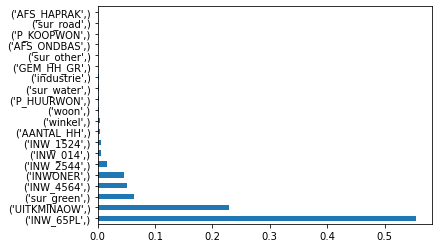

In [8]:
# Create feature importance plot
feat_importances = pd.Series(classifier.feature_importances_, index=columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.savefig('import_rf_z_smote.png', dpi=300, bbox_inches = "tight")

# Make QGIS File

In [9]:
# Create Dataframe with TP, TN, FP, FN and gridnumber
qgis_koppel_train = []
qgis_koppel_test = []
qgis_koppel_val1 = []
qgis_koppel_val2 = []
qgis_train = pd.DataFrame(train.index,columns=["id"])
qgis_test = pd.DataFrame(test.index,columns=["id"])
qgis_val1 = pd.DataFrame(validation["c28992r100"],columns=["c28992r100"])
qgis_val2 = pd.DataFrame(validation2["c28992r100"],columns=["c28992r100"])

for y, yt in zip(y_train, pr_rf):
    if y == 0 and yt == 0:
        qgis_koppel_train.append("TN")
    if y == 0 and yt == 1:
        qgis_koppel_train.append("FN")
    if y == 1 and yt == 0:
        qgis_koppel_train.append("FP")
    if y == 1 and yt == 1:
        qgis_koppel_train.append("TP")

for y, yt in zip(y_test.to_numpy(), p_rf):
    if y == 0 and yt == 0:
        qgis_koppel_test.append("TN")
    if y == 0 and yt == 1:
        qgis_koppel_test.append("FN")
    if y == 1 and yt == 0:
        qgis_koppel_test.append("FP")
    if y == 1 and yt == 1:
        qgis_koppel_test.append("TP")
        
for y, yt in zip(y_val1.to_numpy(), pre_rf):
    if y == 0 and yt == 0:
        qgis_koppel_val1.append("TN")
    if y == 0 and yt == 1:
        qgis_koppel_val1.append("FN")
    if y == 1 and yt == 0:
        qgis_koppel_val1.append("FP")
    if y == 1 and yt == 1:
        qgis_koppel_val1.append("TP")

for y, yt in zip(y_val2.to_numpy(), pred_rf):
    if y == 0 and yt == 0:
        qgis_koppel_val2.append("TN")
    if y == 0 and yt == 1:
        qgis_koppel_val2.append("FN")
    if y == 1 and yt == 0:
        qgis_koppel_val2.append("FP")
    if y == 1 and yt == 1:
        qgis_koppel_val2.append("TP")

qgis_train["label"] = pd.Series(qgis_koppel_train)
qgis_test["label"] = pd.Series(qgis_koppel_test)
qgis_val1["label"] = pd.Series(qgis_koppel_val1)
qgis_val2["label"] = pd.Series(qgis_koppel_val2)

qgis_train.to_csv("qgistrainrfSZ.csv", index=False)
qgis_test.to_csv("qgistestrfSZ.csv", index=False)
qgis_val1.to_csv("qgisval1rfSZ.csv", index=False)
qgis_val2.to_csv("qgisval2rfSZ.csv", index=False)